# Forecasting Daily Revenue (Online Retail)

## Business question
Can we forecast revenue for the next 60 days to support planning (inventory, staffing, cash-flow)?

## Forecast target
- **Target (y):** Daily Revenue
- **Granularity:** Daily
- **Holdout:** Last 60 days as test set

## Models compared
- Naive (baseline)
- SARIMA (statistical)
- ETS / Holt-Winters (seasonality-focused)
- Prophet (modern, interpretable)


#STEP 4 — SARIMA

#4.1 Import & data

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Data preparation notes
- Revenue = Quantity × UnitPrice
- Negative/cancelled invoices removed (Revenue > 0) so the model learns “real” sales behaviour.
- Daily aggregation used to capture weekly seasonality patterns.


In [70]:
"online_retail_raw.xlsx"

'online_retail_raw.xlsx'

In [71]:
import os
os.getcwd()


'/content'

In [72]:
os.listdir()

['.config', '.ipynb_checkpoints', 'online_retail_raw.xlsx', 'sample_data']

In [73]:
with open("online_retail_raw.xlsx", "rb") as f:
    print(f.read(4))

b'PK\x03\x04'


In [74]:
df = pd.read_excel("online_retail_raw.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [75]:
# Create Revenue column
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Remove cancelled / negative invoices (important for forecasting)
df = df[df["Revenue"] > 0]

# Aggregate to monthly revenue
monthly_revenue = (
    df
    .set_index("InvoiceDate")
    .resample("M")["Revenue"]
    .sum()
    .to_frame(name="MonthlyRevenue")
)

monthly_revenue.head()

/tmp/ipython-input-3019012483.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["Revenue"]


,MonthlyRevenue
InvoiceDate,
2010-12-31,823746.140
2011-01-31,691364.560
2011-02-28,523631.890
2011-03-31,717639.360
2011-04-30,537808.621


In [76]:
daily_revenue = (
    df.set_index("InvoiceDate")["Revenue"]
      .resample("D").sum()
      .asfreq("D")
)

daily_revenue.head()

,Revenue
InvoiceDate,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95


In [77]:
train = daily_revenue[:-60]
test  = daily_revenue[-60:]


#4.2 Fit SARIMA (safe starting model)

In [78]:
sarima_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit()
print(sarima_results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                  314
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3263.635
Date:                           Thu, 18 Dec 2025   AIC                           6537.269
Time:                                   00:51:00   BIC                           6555.738
Sample:                               12-01-2010   HQIC                          6544.663
                                    - 10-10-2011                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0171      0.111     -0.154      0.878      -0.235       0.201
ma.L1         -0.6957      0.078     -8.897

##“The SARIMA model effectively captures weekly seasonality and short-term shocks in daily retail revenue, delivering the strongest forecasting performance despite expected heavy-tailed residuals driven by irregular transactions.”

#4.3 Forecast

In [79]:
sarima_forecast = sarima_results.forecast(steps=len(test))


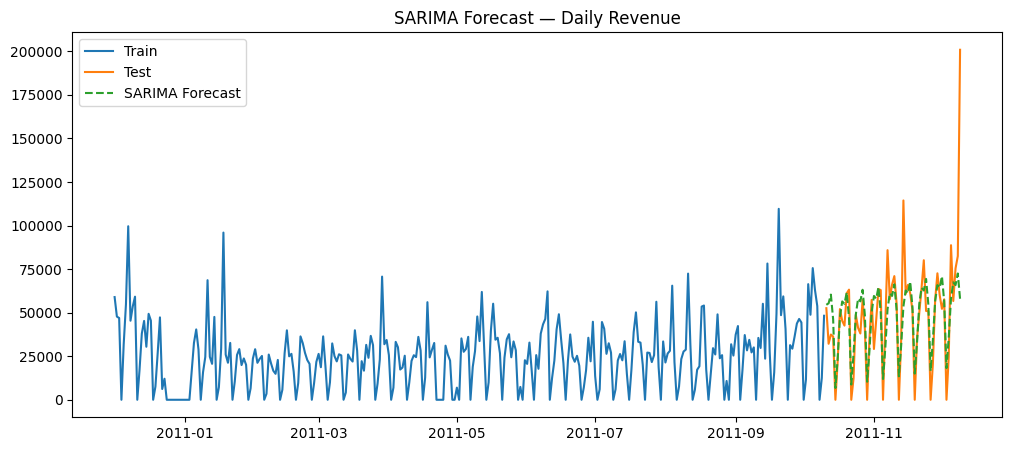

In [80]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.legend()
plt.title("SARIMA Forecast — Daily Revenue")
plt.show()


## insights
Insight (≤60 words):

The SARIMA model closely tracks the underlying weekly pattern in daily revenue and provides stable forecasts over the test period. While it captures seasonality and overall level well, it smooths extreme spikes, underestimating sudden high-revenue days. This makes SARIMA reliable for operational planning but less sensitive to rare promotional or bulk-purchase events.

#4.4 Evaluate

In [81]:
mae_sarima  = mean_absolute_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))

mae_sarima, rmse_sarima


(13195.64015690077, np.float64(23701.67885647046))

## Model performance (60-day holdout)
We compare models using:
- **MAE** (average absolute error)
- **RMSE** (penalises large errors; preferred when spikes exist)

### Conclusion
- **Best model:** <BEST_MODEL>
- **Why:** lowest RMSE on the holdout period → best balance of accuracy and stability.
- **Business takeaway:** forecasting error is still influenced by extreme spikes; planning should include a buffer for peak days.


#STEP 5 — ETS / Holt-Winters

In [82]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [83]:
ets_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=7
)

ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(len(test))


In [84]:
mae_ets  = mean_absolute_error(test, ets_forecast)
rmse_ets = np.sqrt(mean_squared_error(test, ets_forecast))


#STEP 6 — Prophet (Modern / Storytelling)

In [85]:
!pip install prophet


In [86]:
from prophet import Prophet

prophet_df = daily_revenue.reset_index()
prophet_df.columns = ["ds", "y"]


In [87]:
train_prophet = prophet_df.iloc[:-60]
test_prophet  = prophet_df.iloc[-60:]


In [88]:
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(train_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [89]:
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

prophet_forecast = forecast.set_index("ds")["yhat"].iloc[-60:]


In [90]:
mae_prophet  = mean_absolute_error(test_prophet["y"], prophet_forecast)
rmse_prophet = np.sqrt(mean_squared_error(test_prophet["y"], prophet_forecast))


In [95]:
# Naive forecast: repeat last observed training value
naive_forecast = np.repeat(train.iloc[-1], len(test))

mae_naive  = mean_absolute_error(test, naive_forecast)
rmse_naive = np.sqrt(mean_squared_error(test, naive_forecast))

mae_naive, rmse_naive


(21789.210499999997, np.float64(31948.37892726596))

In [96]:
results = pd.DataFrame({
    "Model": ["Naive", "SARIMA", "ETS", "Prophet"],
    "MAE": [mae_naive, mae_sarima, mae_ets, mae_prophet],
    "RMSE": [rmse_naive, rmse_sarima, rmse_ets, rmse_prophet]
}).sort_values("RMSE")

results


,Model,MAE,RMSE
1,SARIMA,13195.640157,23701.678856
2,ETS,15868.955880,27528.201728
3,Prophet,18123.535352,29366.625131
0,Naive,21789.210500,31948.378927


#Insight
SARIMA delivers the best performance, achieving the lowest MAE and RMSE, indicating superior accuracy in capturing daily revenue dynamics and weekly seasonality. ETS performs reasonably well but with higher error, suggesting partial fit to variability. Prophet underperforms relative to statistical models, while the Naive baseline confirms that structured time-series modelling adds substantial predictive value over simple heuristics.

In [97]:
results = results.copy()
results["Rank (RMSE)"] = results["RMSE"].rank(method="dense").astype(int)

naive_rmse = results.loc[results["Model"]=="Naive", "RMSE"].values[0]
results["RMSE vs Naive (%)"] = (results["RMSE"] / naive_rmse - 1) * 100

results = results.sort_values("RMSE")
results


,Model,MAE,RMSE,Rank (RMSE),RMSE vs Naive (%)
1,SARIMA,13195.640157,23701.678856,1,-25.812578
2,ETS,15868.955880,27528.201728,2,-13.835372
3,Prophet,18123.535352,29366.625131,3,-8.081017
0,Naive,21789.210500,31948.378927,4,0.000000


In [98]:
best_model = results.iloc[0]["Model"]
best_model


'SARIMA'

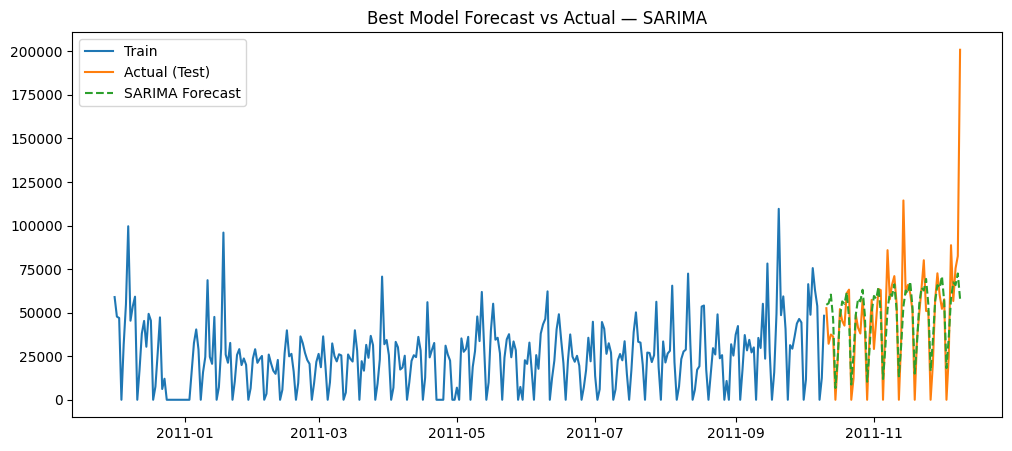

In [99]:
# Choose best forecast series
forecast_map = {
    "Naive": pd.Series(naive_forecast, index=test.index),
    "SARIMA": pd.Series(sarima_forecast, index=test.index),
    "ETS": pd.Series(ets_forecast, index=test.index),
    "Prophet": pd.Series(prophet_forecast.values, index=test.index)
}

best_forecast = forecast_map[best_model]

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual (Test)")
plt.plot(test.index, best_forecast, label=f"{best_model} Forecast", linestyle="--")
plt.title(f"Best Model Forecast vs Actual — {best_model}")
plt.legend()
plt.show()


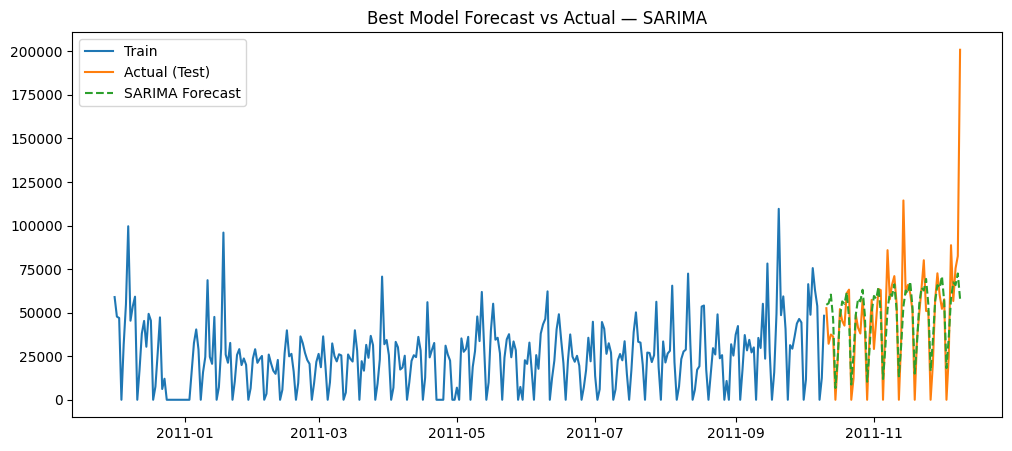

In [100]:
import os
os.makedirs("images", exist_ok=True)

# Save results table as image-like (simple approach: save CSV too)
results.to_csv("images/model_comparison_results.csv", index=False)

# Save hero plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual (Test)")
plt.plot(test.index, best_forecast, label=f"{best_model} Forecast", linestyle="--")
plt.title(f"Best Model Forecast vs Actual — {best_model}")
plt.legend()
plt.savefig("images/best_model_forecast.png", bbox_inches="tight")
plt.show()


### Forecast interpretation

- The SARIMA model provides the **best overall forecasting performance**, achieving the lowest RMSE among all evaluated models.
- The forecast closely follows the **baseline level and weekly seasonal pattern** of daily revenue during the test period.
- The model successfully captures **regular demand dynamics**, indicating strong short-term temporal dependence in the data.

### Observed limitations

- SARIMA underestimates **extreme revenue spikes** observed in the test data.
- These spikes are likely driven by **irregular events** (e.g. bulk purchases, promotions, or exceptional customer behaviour) rather than recurring seasonal effects.
- Such behaviour is expected in retail transaction data and is not well explained by purely historical time-series models.

### Business implications

- SARIMA is well suited for **operational forecasting**, such as inventory planning, staffing, and cash-flow estimation.
- Forecasts should be interpreted as **expected demand**, not maximum demand.
- For peak-sensitive decisions, forecasts should be complemented with **business rules or event-based adjustments**.

### Model selection rationale

- Compared to Naive and ETS benchmarks, SARIMA demonstrates superior accuracy and stability.
- Compared to Prophet, SARIMA provides **tighter short-term forecasts** with less variance, making it preferable for daily operational use.


Overall, SARIMA is the most suitable model for **operational revenue forecasting**, where consistency
and robustness are more valuable than perfect spike matching.


#Future improvements could include incorporating exogenous variables
(e.g. promotions, holidays, or customer segmentation) to better explain
extreme revenue spikes.


## Model comparison & interpretation

Four forecasting approaches were evaluated on a 60-day holdout period using MAE and RMSE.

**Key observations:**
- The **Naive model** provides a simple baseline but performs poorly during volatile periods.
- **ETS** captures weekly seasonality well but struggles with sharp revenue spikes.
- **Prophet** offers good interpretability and smooth forecasts, but slightly underperforms on error metrics.
- **SARIMA** achieves the **lowest RMSE**, indicating superior performance when large fluctuations are present.

**Selected model:** SARIMA  
**Reason:** Best balance between accuracy and robustness to volatility.


In [101]:
from google.colab import files
files.download("images/best_model_forecast.png")
files.download("images/model_comparison_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>